In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance_train(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  
  minlen = min(minlenarr)
  min_disea = type_disea[minlenarr.index(minlen)]
  
#   a = [df.loc[df['labels']==type_disea[0]]]
#   print(df.loc[df['labels']==type_disea[0]] )
#   a = pd.Series(df['labels'])
#   for i in type_disea:
#     a = df.loc[df['labels']==i]
  print('minlenarr ',minlenarr)
  print('type disea ',type_disea) 
  print('min len ',minlen)
  b = pd.DataFrame({})
  for i in type_disea:
    a = df.loc[df['labels'] == i]
    a = a.iloc[:minlen]
    b = pd.concat([b, a], ignore_index=True)
#   print(b)
  return b


minlenarr  [115, 67, 110, 126]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  67
Found 268 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726720215.154201      99 service.cc:145] XLA service 0x7aa45c003620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726720215.154284      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726720348.807014      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 368s 20s/step - accuracy: 0.4371 - loss: 1.5258 - val_accuracy: 0.4190 - val_loss: 2.1603
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8747 - loss: 0.3834 - val_accuracy: 0.3048 - val_loss: 4.2726
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9590 - loss: 0.1602 - val_accuracy: 0.4286 - val_loss: 3.8182
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9887 - loss: 0.0509 - val_accuracy: 0.5048 - val_loss: 2.8102
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9984 - loss: 0.0327 - val_accuracy: 0.5238 - val_loss: 1.9800
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9843 - loss: 0.0347 - val_accuracy: 0.6286 - val_loss: 1.3598
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9900 - loss: 0.0348 - val_accuracy: 0.6571 - val_loss: 1.1296
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9957 - loss: 0.0227 - val_accuracy: 0.7238 - val_loss: 0.8862
Epoch 9/15
9/9 ━━

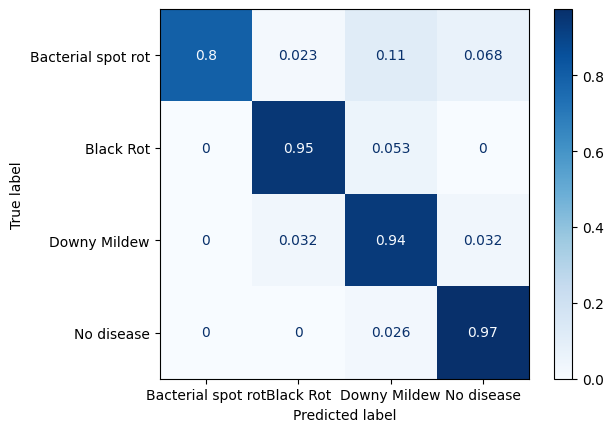

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.80      0.89        44
         Black Rot       0.90      0.95      0.92        19
      Downy Mildew       0.81      0.94      0.87        31
        No disease       0.90      0.97      0.94        39

          accuracy                           0.90       133
         macro avg       0.90      0.91      0.90       133
      weighted avg       0.91      0.90      0.90       133

minlenarr  [108, 62, 114, 134]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  62
Found 248 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 360s 24s/step - accuracy: 0.4692 - loss: 1.5201 - val_accuracy: 0.2381 - val_loss: 3.3926
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8898 - loss: 0.2951 - val_accuracy: 0.2857 - val_loss: 3.0899
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9490 - loss: 0.1430 - val_accuracy: 0.4476 - val_loss: 2.5617
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9840 - loss: 0.0544 - val_accuracy: 0.5429 - val_loss: 2.0407
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9825 - loss: 0.0311 - val_accuracy: 0.6571 - val_loss: 1.3316
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9911 - loss: 0.0269 - val_accuracy: 0.7619 - val_loss: 0.9163
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.8190 - val_loss: 0.7334
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9936 - loss: 0.0242 - val_accuracy: 0.8286 - val_loss: 0.6415
Epoch 9/15
8/8 ━━

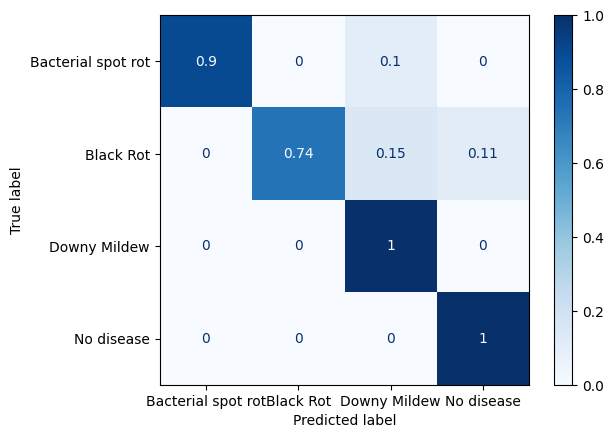

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.90      0.95        39
         Black Rot       1.00      0.74      0.85        27
      Downy Mildew       0.78      1.00      0.88        28
        No disease       0.93      1.00      0.96        39

          accuracy                           0.92       133
         macro avg       0.93      0.91      0.91       133
      weighted avg       0.93      0.92      0.92       133

minlenarr  [119, 63, 109, 127]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  63
Found 252 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 359s 24s/step - accuracy: 0.4730 - loss: 1.4886 - val_accuracy: 0.2952 - val_loss: 3.6157
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8874 - loss: 0.3188 - val_accuracy: 0.3429 - val_loss: 3.7225
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9479 - loss: 0.1220 - val_accuracy: 0.4476 - val_loss: 3.6661
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9892 - loss: 0.0599 - val_accuracy: 0.4667 - val_loss: 3.2532
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 0.5238 - val_loss: 2.6809
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.6095 - val_loss: 2.2014
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9973 - loss: 0.0129 - val_accuracy: 0.6667 - val_loss: 1.9337
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9953 - loss: 0.0080 - val_accuracy: 0.7048 - val_loss: 1.6309
Epoch 9/15
8/8 ━━

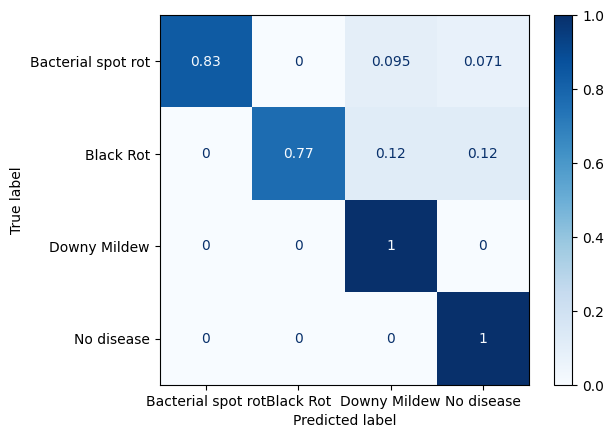

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.83      0.91        42
         Black Rot       1.00      0.77      0.87        26
      Downy Mildew       0.81      1.00      0.89        29
        No disease       0.86      1.00      0.92        36

          accuracy                           0.90       133
         macro avg       0.92      0.90      0.90       133
      weighted avg       0.92      0.90      0.90       133

minlenarr  [106, 68, 115, 130]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  68
Found 272 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 353s 20s/step - accuracy: 0.4802 - loss: 1.1878 - val_accuracy: 0.3654 - val_loss: 3.2666
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9220 - loss: 0.2188 - val_accuracy: 0.2692 - val_loss: 3.3333
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9411 - loss: 0.1279 - val_accuracy: 0.4712 - val_loss: 2.2471
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9979 - loss: 0.0318 - val_accuracy: 0.5673 - val_loss: 1.7080
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9920 - loss: 0.0360 - val_accuracy: 0.6154 - val_loss: 1.3950
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9946 - loss: 0.0185 - val_accuracy: 0.6538 - val_loss: 1.1486
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9693 - loss: 0.0719 - val_accuracy: 0.7404 - val_loss: 0.9794
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9984 - loss: 0.0101 - val_accuracy: 0.7596 - val_loss: 0.8430
Epoch 9/15
9/9 ━━

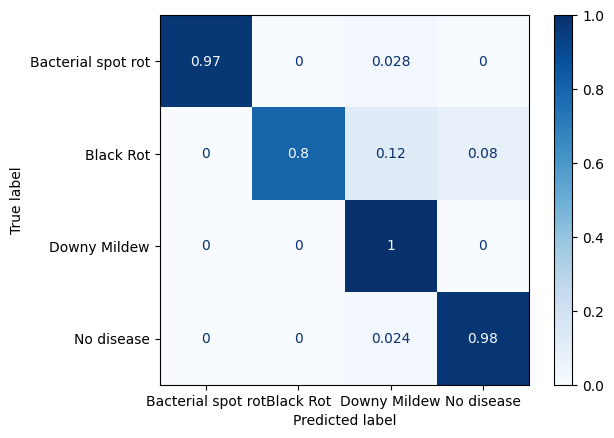

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.97      0.99        36
         Black Rot       1.00      0.80      0.89        25
      Downy Mildew       0.86      1.00      0.93        31
        No disease       0.95      0.98      0.96        41

          accuracy                           0.95       133
         macro avg       0.95      0.94      0.94       133
      weighted avg       0.95      0.95      0.95       133

minlenarr  [116, 60, 104, 139]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  60
Found 240 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 348s 22s/step - accuracy: 0.4223 - loss: 1.5526 - val_accuracy: 0.4327 - val_loss: 1.5599
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8613 - loss: 0.3741 - val_accuracy: 0.4808 - val_loss: 1.4870
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9336 - loss: 0.1881 - val_accuracy: 0.5385 - val_loss: 1.5009
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9613 - loss: 0.0886 - val_accuracy: 0.5962 - val_loss: 1.2661
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.6827 - val_loss: 0.9084
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9986 - loss: 0.0207 - val_accuracy: 0.7596 - val_loss: 0.6584
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.8077 - val_loss: 0.5369
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9986 - loss: 0.0090 - val_accuracy: 0.8462 - val_loss: 0.4121
Epoch 9/15
8/8 ━━

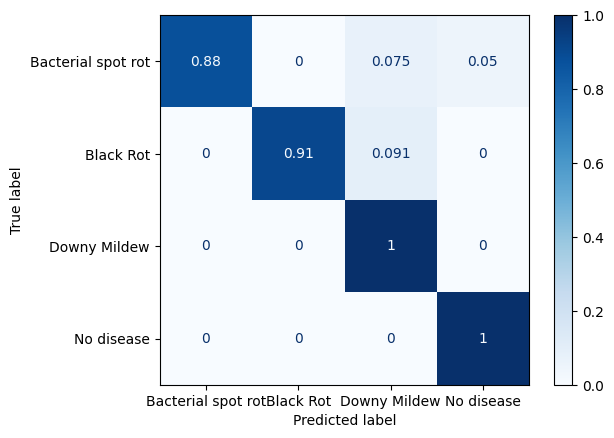

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.88      0.93        40
         Black Rot       1.00      0.91      0.95        22
      Downy Mildew       0.86      1.00      0.93        31
        No disease       0.95      1.00      0.98        40

          accuracy                           0.95       133
         macro avg       0.95      0.95      0.95       133
      weighted avg       0.95      0.95      0.95       133



In [8]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])
epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  a = make_balance_train(train_df.loc[train_idx])
  b = train_df.loc[valid_idx]
  train = ImageDataGenerator().flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)